# Data pre-processing
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

## 1. Integrácia a čistenie dát

### Zadanie  
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
    
### Riešenie  

#### Načítanie datasetov


In [2]:
# read labor and profiles dataset
df_labor = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles = pd.read_csv('../../data/profiles.csv', sep='\t')

#### Spojenie datasetov  

 - spojenie datasetov riešime metódou dataframu **merge** na základe *_ssn_* a *_name_*:

In [3]:
df_merged = df_labor.merge(df_profiles, on=['ssn', 'name'], how='inner')
df_backup = df_merged.copy(deep=True)
df_merged.head()

,Unnamed: 0_x,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,name,...,ssn,hematokrit,Unnamed: 0_y,sex,current_location,blood_group,residence,birthdate,race,address
0,0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,Kathryn Wagner,...,887-91-9698,5.40103,249,F,"(Decimal('11.9802965'), Decimal('-21.280545'))",A-,"5232 Leah Cliff\nVeronicaborough, HI 57977",18 Jul 1990,Black,Unit 2672 Box 7318\nDPO AE 84546
1,1031,7.61474,8.32651,6.31797,103.40018,7.94740,68.19111,58.87708,married,Kathryn Wagner,...,887-91-9698,6.98459,249,F,"(Decimal('11.9802965'), Decimal('-21.280545'))",A-,"5232 Leah Cliff\nVeronicaborough, HI 57977",18 Jul 1990,Black,Unit 2672 Box 7318\nDPO AE 84546
2,4028,4.48849,4.23617,4.02665,81.31141,6.17807,61.68013,38.42977,married,Kathryn Wagner,...,887-91-9698,8.37171,249,F,"(Decimal('11.9802965'), Decimal('-21.280545'))",A-,"5232 Leah Cliff\nVeronicaborough, HI 57977",18 Jul 1990,Black,Unit 2672 Box 7318\nDPO AE 84546
3,5988,8.29277,5.51242,4.48835,47.93897,7.92536,64.28436,31.94522,separated,Kathryn Wagner,...,887-91-9698,5.91413,249,F,"(Decimal('11.9802965'), Decimal('-21.280545'))",A-,"5232 Leah Cliff\nVeronicaborough, HI 57977",18 Jul 1990,Black,Unit 2672 Box 7318\nDPO AE 84546
4,1,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,Frank Becker,...,506-37-0250,7.68167,2387,M,"(Decimal('61.160467'), Decimal('-22.068344'))",AB+,"48442 Briggs Causeway Suite 060\nNashberg, CO ...",1906-08-23,White,4018 English Springs Apt. 997\nPort Kevinmouth...


 - pozrieme sa na info o stĺpcoch:

In [4]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0_x      10035 non-null  int64  
 1   hemoglobin        10005 non-null  float64
 2   leukocyty         10004 non-null  float64
 3   etytr             10005 non-null  float64
 4   weight            10035 non-null  float64
 5   trombocyty        10005 non-null  float64
 6   ast               10005 non-null  float64
 7   alp               10004 non-null  float64
 8   relationship      10035 non-null  object 
 9   name              10035 non-null  object 
 10  alt               10005 non-null  float64
 11  hbver             10005 non-null  float64
 12  smoker            10035 non-null  object 
 13  erytrocyty        10005 non-null  float64
 14  er-cv             10005 non-null  float64
 15  indicator         10035 non-null  float64
 16  ssn               10035 non-null  object

 - pozrieme sa na počet NaN hodnôt:

In [5]:
df_merged.isna().sum()

Unnamed: 0_x         0
hemoglobin          30
leukocyty           31
etytr               30
weight               0
trombocyty          30
ast                 30
alp                 31
relationship         0
name                 0
alt                 30
hbver               30
smoker               0
erytrocyty          30
er-cv               30
indicator            0
ssn                  0
hematokrit          30
Unnamed: 0_y         0
sex                  0
current_location     0
blood_group          0
residence            0
birthdate            0
race                 0
address              0
dtype: int64

 - vidíme, že dataset má viaceré problémy, ktoré musíme riešiť - transformáciu na numerické dáta, nahradenie až 332 NaN hodnôt a podobne, preto si uź teraz definujeme významné funkcie, ktoré budeme potrebovať neskôr doplnené aj s príslušnou dokumentáciu kódu:

In [6]:
def meanFunct(data, column):
    """
    Computes mean of an column and fills NaN values in column based on mean.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param column: Feature 
    :returns: pandas.core.frame.DataFrame
    """
    data[column] = data[column].fillna(data[column].mean())
    return data
    
def medianFunct(data, column):
    """
    Computes median of an column and fills NaN values in column based on median.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param column: Feature 
    :returns: pandas.core.frame.DataFrame
    """
    data[column] = data[column].fillna(data[column].median())
    return data
    
def controlFunct(data, column):
    """
    Control function, prints from dataset column.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param column: Feature 
    """
    print(data[column].loc[data[column].isna(),])
    print(sum(data[column].isna()))
    
def knnFunct(data, column):
    """
    Computes KNN of an column and fills NaN values in column based on KNN.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param column: Feature 
    :returns: pandas.core.frame.DataFrame
    """
    imputer = KNNImputer(n_neighbors=5)
    copy = data[column].values.reshape(-1,1)
    imputer.fit(copy)
    Xtrans = imputer.transform(copy)
    data[column] = pd.DataFrame(Xtrans)
    return data
    
def regressionFunct(data, column):
    """
    Computes linear regresion of an column and fills NaN values in column based on linear regresion.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param column: Feature 
    :returns: pandas.core.frame.DataFrame
    """
    data[column].interpolate(method='linear', inplace=True)
    return data

def ratioFunct(data, columnToFill, corrColumn):
    """
    Computes ratio of an corrColumn and columnToFill; fills NaN values in column based on ratio.
    
    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param columnToFill: Feature to fill NaN values
    :param corrColumn: Feature which correlates with columnToFill
    :returns: pandas.core.frame.DataFrame
    """
    ratio = data[corrColumn]/data[columnToFill]
    data[columnToFill] = data[columnToFill].fillna(data[corrColumn] * ratio.mean())
    return data
    
def dropCol(data, *args):
    """
    Function to delete columns specified in *args to be deleted from data.

    :param data: The dataset is instance of pandas.core.frame.DataFrame
    :param *args: tuple of *str, specifing cols to be dropped
    :returns: pandas.core.frame.DataFrame without columns specified in *args
    :raises keyError: raises an exception in case column was not found
    """
    try:
        return data.drop(list(args), axis=1)
    except KeyError:
        print(f'Something from {args} not found in dataset!') 
        return data
    
def age(born):
    """
    Computes current age.
    
    :param born: Date of birth 
    returns: Current age
    """
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

#### 1. Dataset profilov

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný, v zlúčenom datasete je pod stĺpcom **Unnamed: 0_y**  

In [7]:
df_merged=dropCol(df_merged, 'Unnamed: 0_y')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0_x      10035 non-null  int64  
 1   hemoglobin        10005 non-null  float64
 2   leukocyty         10004 non-null  float64
 3   etytr             10005 non-null  float64
 4   weight            10035 non-null  float64
 5   trombocyty        10005 non-null  float64
 6   ast               10005 non-null  float64
 7   alp               10004 non-null  float64
 8   relationship      10035 non-null  object 
 9   name              10035 non-null  object 
 10  alt               10005 non-null  float64
 11  hbver             10005 non-null  float64
 12  smoker            10035 non-null  object 
 13  erytrocyty        10005 non-null  float64
 14  er-cv             10005 non-null  float64
 15  indicator         10035 non-null  float64
 16  ssn               10035 non-null  object

 - **Atribút name** - tento stĺpec je v poriadku, kódovať do numerického tvaru ho nebudeme, potrebný pre spojenie 2 dataframeov, avšak po spojení dataframov je nepotrebný, a preto ho odstránime 

In [8]:
df_merged["name"].head()

0    Kathryn Wagner
1    Kathryn Wagner
2    Kathryn Wagner
3    Kathryn Wagner
4      Frank Becker
Name: name, dtype: object

In [9]:
df_merged=dropCol(df_merged, 'name')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0_x      10035 non-null  int64  
 1   hemoglobin        10005 non-null  float64
 2   leukocyty         10004 non-null  float64
 3   etytr             10005 non-null  float64
 4   weight            10035 non-null  float64
 5   trombocyty        10005 non-null  float64
 6   ast               10005 non-null  float64
 7   alp               10004 non-null  float64
 8   relationship      10035 non-null  object 
 9   alt               10005 non-null  float64
 10  hbver             10005 non-null  float64
 11  smoker            10035 non-null  object 
 12  erytrocyty        10005 non-null  float64
 13  er-cv             10005 non-null  float64
 14  indicator         10035 non-null  float64
 15  ssn               10035 non-null  object 
 16  hematokrit        10005 non-null  float6

 - **Atribút sex** - tento stĺpec treba pretransformovať z typu *_object_* na numerický typ nasledovne: **1 - žena**, **0 - muž**

In [10]:
df_merged["sex"].head()

0    F
1    F
2    F
3    F
4    M
Name: sex, dtype: object

In [11]:
df_merged["sex"].replace({"M": 0, "F": 1}, inplace=True)
df_merged = df_merged.astype({'sex': 'float64'})
df_merged["sex"].value_counts()

0.0    5104
1.0    4931
Name: sex, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty M a F za 0 a 1 ako dokazuje nasledovná bunka:

In [12]:
df_merged["sex"].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: sex, dtype: float64

- **Atribút current_location** - tento atribút nebudeme potrebovať pri strojovom učení, nebudeme riešiť kódovanie na numerický tvar, ale jeho vymazanie

In [13]:
df_merged["current_location"].head()

0    (Decimal('11.9802965'), Decimal('-21.280545'))
1    (Decimal('11.9802965'), Decimal('-21.280545'))
2    (Decimal('11.9802965'), Decimal('-21.280545'))
3    (Decimal('11.9802965'), Decimal('-21.280545'))
4     (Decimal('61.160467'), Decimal('-22.068344'))
Name: current_location, dtype: object

In [14]:
df_merged=dropCol(df_merged, 'current_location')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  10035 non-null  int64  
 1   hemoglobin    10005 non-null  float64
 2   leukocyty     10004 non-null  float64
 3   etytr         10005 non-null  float64
 4   weight        10035 non-null  float64
 5   trombocyty    10005 non-null  float64
 6   ast           10005 non-null  float64
 7   alp           10004 non-null  float64
 8   relationship  10035 non-null  object 
 9   alt           10005 non-null  float64
 10  hbver         10005 non-null  float64
 11  smoker        10035 non-null  object 
 12  erytrocyty    10005 non-null  float64
 13  er-cv         10005 non-null  float64
 14  indicator     10035 non-null  float64
 15  ssn           10035 non-null  object 
 16  hematokrit    10005 non-null  float64
 17  sex           10035 non-null  float64
 18  blood_group   10035 non-nu

 - **Atribút blood_group** - hodnoty typu *_object_* kategorizujeme nasledovne: **1(A+), 2(A-), 3(B+), 4(B-), 5(AB+), 6(AB-), 7(O+) a 8(O-)**

In [15]:
df_merged['blood_group']

0         A-
1         A-
2         A-
3         A-
4        AB+
        ... 
10030    AB-
10031    AB-
10032     O+
10033     O+
10034     O+
Name: blood_group, Length: 10035, dtype: object

In [16]:
df_merged['blood_group'] = df_merged['blood_group'].replace({"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8})
df_merged = df_merged.astype({'blood_group': 'float64'})
df_merged.blood_group.value_counts()

3.0    1306
1.0    1300
8.0    1288
5.0    1271
7.0    1266
2.0    1252
6.0    1191
4.0    1161
Name: blood_group, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty za 1, 2, 3, 4, 5, 6, 7 a 8 ako dokazuje nasledovná bunka:

In [17]:
df_merged["blood_group"].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    5.0
Name: blood_group, dtype: float64

- **Atribút residence** - tento stĺpec je v poriadku, avšak pri strojovom učení ho nebudeme potrebovať, a preto ho odstránime:

In [18]:
df_merged["residence"].head()

0           5232 Leah Cliff\nVeronicaborough, HI 57977
1           5232 Leah Cliff\nVeronicaborough, HI 57977
2           5232 Leah Cliff\nVeronicaborough, HI 57977
3           5232 Leah Cliff\nVeronicaborough, HI 57977
4    48442 Briggs Causeway Suite 060\nNashberg, CO ...
Name: residence, dtype: object

 - **Atribút birthdate** - neobsahuje žiadne chýbajúce hodnoty, avšak je potrebné získať jednotný tvar, pretože súčasný tvar je rôznorodý a zároveň nie je potrebné pre naše účely dátum narodenia pacienta, avšak súčasný vek pacienta môže byť potrebný, a preto nahradíme dátum narodenia za súčasný vek pacienta, ktorý môže byť pre nás viac informatívny

In [19]:
df_merged = dropCol(df_merged, 'residence')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  10035 non-null  int64  
 1   hemoglobin    10005 non-null  float64
 2   leukocyty     10004 non-null  float64
 3   etytr         10005 non-null  float64
 4   weight        10035 non-null  float64
 5   trombocyty    10005 non-null  float64
 6   ast           10005 non-null  float64
 7   alp           10004 non-null  float64
 8   relationship  10035 non-null  object 
 9   alt           10005 non-null  float64
 10  hbver         10005 non-null  float64
 11  smoker        10035 non-null  object 
 12  erytrocyty    10005 non-null  float64
 13  er-cv         10005 non-null  float64
 14  indicator     10035 non-null  float64
 15  ssn           10035 non-null  object 
 16  hematokrit    10005 non-null  float64
 17  sex           10035 non-null  float64
 18  blood_group   10035 non-nu

In [20]:
df_merged['birthdate'] = df_merged['birthdate'].astype('datetime64[ns]')
df_merged['birthdate'].head()

0   1990-07-18
1   1990-07-18
2   1990-07-18
3   1990-07-18
4   1906-08-23
Name: birthdate, dtype: datetime64[ns]

Zároveň nemáme žiadne **NaN** hodnoty v dátume:

In [21]:
df_merged['birthdate'].isna().sum()

0

In [22]:
df_merged['birthdate'] = df_merged['birthdate'].apply(age)
df_merged = df_merged.rename(columns = {'birthdate': 'age'})   # ci nam treba birthdate? 
df_merged = df_merged.astype({'age': 'float64'})
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  10035 non-null  int64  
 1   hemoglobin    10005 non-null  float64
 2   leukocyty     10004 non-null  float64
 3   etytr         10005 non-null  float64
 4   weight        10035 non-null  float64
 5   trombocyty    10005 non-null  float64
 6   ast           10005 non-null  float64
 7   alp           10004 non-null  float64
 8   relationship  10035 non-null  object 
 9   alt           10005 non-null  float64
 10  hbver         10005 non-null  float64
 11  smoker        10035 non-null  object 
 12  erytrocyty    10005 non-null  float64
 13  er-cv         10005 non-null  float64
 14  indicator     10035 non-null  float64
 15  ssn           10035 non-null  object 
 16  hematokrit    10005 non-null  float64
 17  sex           10035 non-null  float64
 18  blood_group   10035 non-nu

 - **Atribút race** - neobsahuje žiadne chýbajúce hodnoty, hodnoty kategorizujeme nasledovne: **1(White), 2(Black), 3(Asian), 4(Hawaiian), 5(Indian)**

In [23]:
df_merged.race.value_counts()

White       5126
Black       2359
Asian        926
Hawaiian     557
Indian       517
black        333
white        120
blsck         97
Name: race, dtype: int64

Najskôr musíme upraviť hodnoty kde je chyba a ktoré majú na začiatku malé písmeno namiesto veľkého.

In [24]:
df_merged['race'] = df_merged['race'].replace({"blsck": "Black", "black": "Black", "white": "White"})
df_merged.race.value_counts()

White       5246
Black       2789
Asian        926
Hawaiian     557
Indian       517
Name: race, dtype: int64

Následne tieto hodnoty kategorizujeme ako sme uviedli vyššie.

In [25]:
df_merged['race'] = df_merged['race'].replace({"White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5})
df_merged = df_merged.astype({'race': 'float64'}) # mame pouzivat category?
df_merged.race.value_counts()

1.0    5246
2.0    2789
3.0     926
4.0     557
5.0     517
Name: race, dtype: int64

In [26]:
df_merged["race"].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    1.0
Name: race, dtype: float64

- **Atribút ssn** - tento stĺpec je v poriadku, avšak po spojení dataframeov je nepotrebný pre naše účely, preto ho odstránime:

In [27]:
df_merged["ssn"].head()

0    887-91-9698
1    887-91-9698
2    887-91-9698
3    887-91-9698
4    506-37-0250
Name: ssn, dtype: object

In [28]:
df_merged = dropCol(df_merged, 'ssn')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  10035 non-null  int64  
 1   hemoglobin    10005 non-null  float64
 2   leukocyty     10004 non-null  float64
 3   etytr         10005 non-null  float64
 4   weight        10035 non-null  float64
 5   trombocyty    10005 non-null  float64
 6   ast           10005 non-null  float64
 7   alp           10004 non-null  float64
 8   relationship  10035 non-null  object 
 9   alt           10005 non-null  float64
 10  hbver         10005 non-null  float64
 11  smoker        10035 non-null  object 
 12  erytrocyty    10005 non-null  float64
 13  er-cv         10005 non-null  float64
 14  indicator     10035 non-null  float64
 15  hematokrit    10005 non-null  float64
 16  sex           10035 non-null  float64
 17  blood_group   10035 non-null  float64
 18  age           10035 non-nu

 - **Atribút address** - tento stĺpec je celý v poriadku, avšak nepotrebný pre naše účely, preto ho nebudeme transformovať, ale odstránime ho:

In [29]:
df_merged["address"].head()

0                     Unit 2672 Box 7318\nDPO AE 84546
1                     Unit 2672 Box 7318\nDPO AE 84546
2                     Unit 2672 Box 7318\nDPO AE 84546
3                     Unit 2672 Box 7318\nDPO AE 84546
4    4018 English Springs Apt. 997\nPort Kevinmouth...
Name: address, dtype: object

In [30]:
df_merged = dropCol(df_merged, 'address')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  10035 non-null  int64  
 1   hemoglobin    10005 non-null  float64
 2   leukocyty     10004 non-null  float64
 3   etytr         10005 non-null  float64
 4   weight        10035 non-null  float64
 5   trombocyty    10005 non-null  float64
 6   ast           10005 non-null  float64
 7   alp           10004 non-null  float64
 8   relationship  10035 non-null  object 
 9   alt           10005 non-null  float64
 10  hbver         10005 non-null  float64
 11  smoker        10035 non-null  object 
 12  erytrocyty    10005 non-null  float64
 13  er-cv         10005 non-null  float64
 14  indicator     10035 non-null  float64
 15  hematokrit    10005 non-null  float64
 16  sex           10035 non-null  float64
 17  blood_group   10035 non-null  float64
 18  age           10035 non-nu

#### Časť datasetu laboratórnych výsledkov  

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný, v zlúčenom datasete je pod stĺpcom **Unnamed: 0_x**  

In [31]:
df_merged = dropCol(df_merged,"Unnamed: 0_x")
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hemoglobin    10005 non-null  float64
 1   leukocyty     10004 non-null  float64
 2   etytr         10005 non-null  float64
 3   weight        10035 non-null  float64
 4   trombocyty    10005 non-null  float64
 5   ast           10005 non-null  float64
 6   alp           10004 non-null  float64
 7   relationship  10035 non-null  object 
 8   alt           10005 non-null  float64
 9   hbver         10005 non-null  float64
 10  smoker        10035 non-null  object 
 11  erytrocyty    10005 non-null  float64
 12  er-cv         10005 non-null  float64
 13  indicator     10035 non-null  float64
 14  hematokrit    10005 non-null  float64
 15  sex           10035 non-null  float64
 16  blood_group   10035 non-null  float64
 17  age           10035 non-null  float64
 18  race          10035 non-nu

 - **Atribút hemoglobin** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *_priemerom_*

In [32]:
controlFunct(df_merged, "hemoglobin")

12     NaN
455    NaN
621    NaN
677    NaN
714    NaN
1020   NaN
1617   NaN
1926   NaN
2231   NaN
2724   NaN
2784   NaN
3279   NaN
3373   NaN
4165   NaN
4221   NaN
4233   NaN
4867   NaN
4989   NaN
5191   NaN
5357   NaN
5510   NaN
6180   NaN
6921   NaN
7259   NaN
7953   NaN
8349   NaN
8509   NaN
8955   NaN
9222   NaN
9684   NaN
Name: hemoglobin, dtype: float64
30


In [33]:
df_merged = meanFunct(df_merged, "hemoglobin")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [34]:
controlFunct(df_merged, "hemoglobin")

Series([], Name: hemoglobin, dtype: float64)
0


 - **Atribút leukocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie cez *ratio*

In [35]:
controlFunct(df_merged, "leukocyty")

107    NaN
362    NaN
483    NaN
601    NaN
1242   NaN
1243   NaN
1544   NaN
1820   NaN
1933   NaN
1962   NaN
2177   NaN
2711   NaN
2774   NaN
3276   NaN
3627   NaN
3986   NaN
4032   NaN
4101   NaN
4779   NaN
5025   NaN
5188   NaN
5191   NaN
5401   NaN
5565   NaN
6167   NaN
6393   NaN
6698   NaN
6796   NaN
7245   NaN
8288   NaN
8695   NaN
Name: leukocyty, dtype: float64
31


In [36]:
df_merged = ratioFunct(df_merged, "leukocyty","etytr")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [37]:
controlFunct(df_merged, "leukocyty")

Series([], Name: leukocyty, dtype: float64)
0


 - **Atribút etytr** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *lineárnou regresiou*

In [38]:
controlFunct(df_merged, "etytr")

50     NaN
426    NaN
467    NaN
551    NaN
782    NaN
1784   NaN
2854   NaN
2889   NaN
3411   NaN
4008   NaN
4692   NaN
5234   NaN
5259   NaN
5652   NaN
5919   NaN
5941   NaN
6452   NaN
6465   NaN
6704   NaN
7897   NaN
8030   NaN
8062   NaN
8769   NaN
8813   NaN
9121   NaN
9285   NaN
9437   NaN
9659   NaN
9675   NaN
9689   NaN
Name: etytr, dtype: float64
30


In [39]:
df_merged = regressionFunct(df_merged, "etytr")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [40]:
controlFunct(df_merged, "etytr")

Series([], Name: etytr, dtype: float64)
0


 - **Atribút weight** - neobsahuje žiadne chýbajúce hodnoty, avšak obsahuje chybné hodnoty(zápornú váhu), ktoré odstránime

In [41]:
df_merged["weight"].loc[df_merged["weight"] < 0]

11      -0.29605
53      -1.13369
168    -15.48039
169     -6.55910
183    -12.45169
          ...   
9793    -9.12601
9881   -11.36831
9890   -22.83756
9960   -12.81497
9984    -6.40237
Name: weight, Length: 203, dtype: float64

In [42]:
weight_median=df_merged["weight"].median()
df_merged.weight = np.where(df_merged.weight < 0, weight_median, df_merged.weight)

In [43]:
df_merged["weight"].loc[df_merged["weight"] < 0].count()

0

In [44]:
df_merged["weight"].loc[df_merged["weight"] < 0]

Series([], Name: weight, dtype: float64)

 - **Atribút trombocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *priemerom*

In [45]:
controlFunct(df_merged, "trombocyty")

1003   NaN
1581   NaN
2093   NaN
2127   NaN
2191   NaN
2675   NaN
2700   NaN
3019   NaN
3090   NaN
3437   NaN
4197   NaN
4847   NaN
5318   NaN
5324   NaN
5397   NaN
5561   NaN
5787   NaN
6331   NaN
7138   NaN
7339   NaN
7611   NaN
8241   NaN
8525   NaN
8587   NaN
8655   NaN
8746   NaN
9414   NaN
9799   NaN
9889   NaN
9949   NaN
Name: trombocyty, dtype: float64
30


In [46]:
df_merged = meanFunct(df_merged, "trombocyty")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [47]:
controlFunct(df_merged, "trombocyty")

Series([], Name: trombocyty, dtype: float64)
0


 - **Atribút ast** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [48]:
controlFunct(df_merged, "ast")

60     NaN
83     NaN
338    NaN
389    NaN
1059   NaN
1545   NaN
1815   NaN
1821   NaN
2088   NaN
2620   NaN
2946   NaN
3043   NaN
3329   NaN
3836   NaN
4711   NaN
4895   NaN
4939   NaN
5051   NaN
5500   NaN
5553   NaN
5875   NaN
5899   NaN
6027   NaN
6442   NaN
6868   NaN
6984   NaN
7077   NaN
7241   NaN
9329   NaN
9682   NaN
Name: ast, dtype: float64
30


In [49]:
df_merged = knnFunct(df_merged, "ast")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [50]:
controlFunct(df_merged, "ast")

Series([], Name: ast, dtype: float64)
0


 - **Atribút alp** -obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [51]:
controlFunct(df_merged, "alp")

270     NaN
915     NaN
1180    NaN
1792    NaN
2074    NaN
2088    NaN
2316    NaN
2446    NaN
2773    NaN
2868    NaN
3376    NaN
3425    NaN
4187    NaN
5208    NaN
5645    NaN
5923    NaN
5947    NaN
6058    NaN
6596    NaN
6719    NaN
6806    NaN
6807    NaN
7166    NaN
7438    NaN
7514    NaN
7786    NaN
8504    NaN
8566    NaN
9726    NaN
9996    NaN
10021   NaN
Name: alp, dtype: float64
31


In [52]:
df_merged = knnFunct(df_merged, "alp")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [53]:
controlFunct(df_merged, "alp")

Series([], Name: alp, dtype: float64)
0


 - **Atribút relationship** - neobsahuje žiadne chýbajúce hodnoty, avšak potrebné je kategorizovať hodnoty, zvolili sme kategorizovanie nasledovane: **1(Married), 2(Divorced), 3(Single), 4(Separated), 5(nop), 6(widowed)**

In [54]:
df_merged.relationship.value_counts()

married      2498
divoced      2488
single       2011
separated    1070
nop          1001
widowed       967
Name: relationship, dtype: int64

In [55]:
df_merged['relationship'] = df_merged['relationship'].replace({"married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6})
df_merged = df_merged.astype({'relationship': 'float64'})
df_merged.relationship.value_counts()

1.0    2498
2.0    2488
3.0    2011
4.0    1070
5.0    1001
6.0     967
Name: relationship, dtype: int64

In [56]:
df_merged["relationship"].head()

0    1.0
1    1.0
2    1.0
3    4.0
4    6.0
Name: relationship, dtype: float64

 - **Atribút alt** - Obsahuje chýbajúce hodnoty, riešime ich nahradenie *lineárnou regresiou*

In [57]:
controlFunct(df_merged, "alt")

47     NaN
1148   NaN
1192   NaN
1589   NaN
2261   NaN
2399   NaN
2634   NaN
3084   NaN
3242   NaN
3382   NaN
3663   NaN
3698   NaN
3741   NaN
3919   NaN
4711   NaN
5961   NaN
6035   NaN
6105   NaN
6146   NaN
6305   NaN
6759   NaN
6870   NaN
6953   NaN
7074   NaN
7363   NaN
7503   NaN
7769   NaN
8668   NaN
9081   NaN
9623   NaN
Name: alt, dtype: float64
30


In [58]:
df_merged = regressionFunct(df_merged, "alt")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [59]:
controlFunct(df_merged, "alt")

Series([], Name: alt, dtype: float64)
0


 - **Atribút erytrocyty** - obsahuje chýbajúce hodnoty

In [60]:
controlFunct(df_merged, "erytrocyty")

276    NaN
1459   NaN
1590   NaN
1620   NaN
2090   NaN
2885   NaN
2996   NaN
3023   NaN
3225   NaN
3305   NaN
4136   NaN
4206   NaN
4378   NaN
4534   NaN
4630   NaN
5884   NaN
6012   NaN
6297   NaN
6385   NaN
6447   NaN
6691   NaN
7517   NaN
7569   NaN
7782   NaN
8503   NaN
8509   NaN
8557   NaN
8667   NaN
9187   NaN
9656   NaN
Name: erytrocyty, dtype: float64
30


In [61]:
df_merged = ratioFunct(df_merged, "erytrocyty","alt")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [62]:
controlFunct(df_merged, "erytrocyty")

Series([], Name: erytrocyty, dtype: float64)
0


 - **Atribút hbver** - obsahuje chýbajúce hodnoty, riešime ich nahradenie cez *ratio*

In [63]:
controlFunct(df_merged, "hbver")

104    NaN
260    NaN
392    NaN
569    NaN
582    NaN
936    NaN
1154   NaN
1433   NaN
1919   NaN
2646   NaN
3500   NaN
3678   NaN
3734   NaN
4004   NaN
4116   NaN
4169   NaN
4350   NaN
4415   NaN
4951   NaN
5988   NaN
6092   NaN
6625   NaN
6805   NaN
7066   NaN
7200   NaN
7757   NaN
8575   NaN
8604   NaN
9220   NaN
9409   NaN
Name: hbver, dtype: float64
30


In [64]:
df_merged = ratioFunct(df_merged, "hbver","erytrocyty")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [65]:
controlFunct(df_merged, "hbver")

Series([], Name: hbver, dtype: float64)
0


 - **Atribút smoker** - neobsahuje žiadne chýbajúce hodnoty, zjednotiť hodnoty(no, Y, yes, N) na dve a kategorizovať hodnoty nasledovane: **1(Yes), 0(No)**

In [66]:
df_merged.smoker.value_counts()

no     5441
Y      2081
yes    1965
N       548
Name: smoker, dtype: int64

In [67]:
df_merged['smoker'] = df_merged['smoker'].replace({"no": 0, "N": 0, "yes": 1, "Y": 1})
df_merged = df_merged.astype({'smoker': 'float64'})
df_merged.smoker.value_counts()

0.0    5989
1.0    4046
Name: smoker, dtype: int64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [68]:
df_merged["smoker"].head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: smoker, dtype: float64

 - **Atribút er-cv** - obsahuje chýbajúce hodnoty

In [69]:
controlFunct(df_merged, "er-cv")

156     NaN
808     NaN
953     NaN
1351    NaN
1436    NaN
1747    NaN
1854    NaN
2102    NaN
2131    NaN
2135    NaN
2551    NaN
2734    NaN
2875    NaN
3816    NaN
3834    NaN
4127    NaN
4189    NaN
4824    NaN
4931    NaN
5067    NaN
5622    NaN
6493    NaN
7421    NaN
7508    NaN
7534    NaN
7761    NaN
8666    NaN
9600    NaN
9714    NaN
10026   NaN
Name: er-cv, dtype: float64
30


In [70]:
df_merged = medianFunct(df_merged, "er-cv")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [71]:
controlFunct(df_merged, "er-cv")

Series([], Name: er-cv, dtype: float64)
0


 - **Atribút indicator** - neobsahuje žiadne chýbajúce hodnoty, zmeniť dátový typ stĺpcu

In [72]:
df_merged = df_merged.astype({'indicator': 'float64'})
df_merged.indicator.value_counts()

1.0    6437
0.0    3598
Name: indicator, dtype: int64

In [73]:
df_merged["indicator"].head()

0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: indicator, dtype: float64

 - **Atribút hematokrit** - obsahuje chýbajúce hodnoty

In [74]:
controlFunct(df_merged, "hematokrit")

315    NaN
754    NaN
1262   NaN
1275   NaN
1593   NaN
1743   NaN
1791   NaN
2723   NaN
3010   NaN
4194   NaN
4322   NaN
4747   NaN
5297   NaN
5477   NaN
6246   NaN
6364   NaN
6633   NaN
6973   NaN
7310   NaN
7351   NaN
7428   NaN
7499   NaN
8291   NaN
8509   NaN
8980   NaN
9136   NaN
9285   NaN
9440   NaN
9809   NaN
9893   NaN
Name: hematokrit, dtype: float64
30


In [75]:
df_merged = medianFunct(df_merged, "hematokrit")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [76]:
controlFunct(df_merged, "hematokrit")

Series([], Name: hematokrit, dtype: float64)
0


#### Deduplikácia (odstránenie duplikátov)

In [77]:
df_merged.duplicated(keep=False).value_counts()

False    9837
True      198
dtype: int64

In [78]:
df_merged=df_merged.drop_duplicates()
df_merged.duplicated(keep=False).value_counts()

False    9936
dtype: int64

#### Outliers

In [79]:
def outlier_funct(column):
    global df_merged
    df_merged.loc[df_merged[column] < df_merged[column].quantile(.05), column] = df_merged[column].quantile(.05)
    df_merged.loc[df_merged[column] > df_merged[column].quantile(.95) , column] = df_merged[column].quantile(.95) 

def release_outlier_funct():
    global df_merged
    outlier_funct('leukocyty')
    outlier_funct('hemoglobin')
    outlier_funct('erytrocyty')


def outlier_funct2(column):
    global df_merged
    if ((stats.skew(df_merged[column]) < -2) or (stats.skew(df_merged[column]) > 2)):
        df_merged[column] = np.log(df_merged[column]+ (-df_merged[column].min()))
    df_merged.loc[df_merged[column] < df_merged[column].quantile(.05), column] = df_merged[column].quantile(.05)
    df_merged.loc[df_merged[column] > df_merged[column].quantile(.95) , column] = df_merged[column].quantile(.95) 

def release_outlier_funct2():
    global df_merged
    outlier_funct2('leukocyty')
    outlier_funct2('hemoglobin')
    outlier_funct2('erytrocyty')



In [80]:
release_outlier_funct()

<AxesSubplot:>

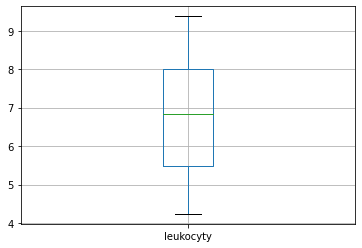

In [81]:
df_merged.boxplot(column=['leukocyty'])

In [82]:
release_outlier_funct2()

<AxesSubplot:>

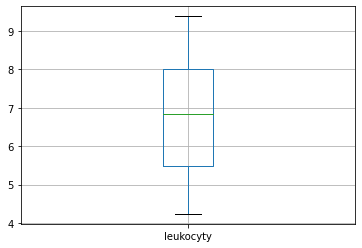

In [83]:
df_merged.boxplot(column=['leukocyty'])

Na základe **info** je potrebné riešiť transformáciu viacerých údajov na numerické

## 2. Realizácia predspracovania dát 

### Zadanie  
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)
    
### Riešenie



In [84]:
training_data, testing_data = train_test_split(df_merged, test_size=0.2, random_state=25)

In [85]:
def scalingFunct(df_toScale):   
    min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))
    scaled_dataframe = min_max_scaler.fit_transform(df_toScale.values.reshape(-1,1))
    return scaled_dataframe

def standardisatingFunct(df_toScale):
    Standardisation = preprocessing.StandardScaler()
    scaled_dataframe = Standardisation.fit_transform(df_toScale.values.reshape(-1,1))
    return scaled_dataframe

def powerTransform(df_toTransform):
    return power_transform(df_toTransform.values.reshape(-1,1))

In [86]:
df_merged["ast"] = scalingFunct(df_merged["ast"])
df_merged["ast"].head()

0    0.618501
1    0.681911
2    0.616801
3    0.642844
4    0.669072
Name: ast, dtype: float64

In [87]:
df_merged["alp"] = standardisatingFunct(df_merged["alp"])
df_merged["alp"].head()

0    0.495757
1   -0.657840
2   -1.735067
3   -2.076693
4    0.982645
Name: alp, dtype: float64

In [88]:
df_merged["alt"] = powerTransform(df_merged["alt"])
df_merged["alt"].head()

0    0.676600
1   -0.559195
2   -0.351916
3    0.214254
4   -0.898046
Name: alt, dtype: float64

In [89]:
df_merged.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,age,race
0,6.772990,5.28153,4.79087,104.22450,7.22472,0.618501,0.495757,1.0,0.676600,9.04461,0.0,7.94417,61.31451,0.0,5.40103,1.0,2.0,31.0,2.0
1,7.614740,8.32651,6.31797,103.40018,7.94740,0.681911,-0.657840,1.0,-0.559195,5.16036,1.0,4.59597,55.12010,1.0,6.98459,1.0,2.0,31.0,2.0
2,4.747716,4.23617,4.02665,81.31141,6.17807,0.616801,-1.735067,1.0,-0.351916,3.85662,1.0,5.47003,59.69653,1.0,8.37171,1.0,2.0,31.0,2.0
3,8.061906,5.51242,4.48835,47.93897,7.92536,0.642844,-2.076693,4.0,0.214254,8.15193,1.0,4.55800,58.92745,0.0,5.91413,1.0,2.0,31.0,2.0
4,6.352170,5.45245,3.34754,65.03608,7.00407,0.669072,0.982645,6.0,-0.898046,9.09262,0.0,5.33302,58.00624,0.0,7.68167,0.0,5.0,115.0,1.0


## 3. Výber atribútov pre strojové učenie

### Zadanie  
- Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”.
- Zoradíte tie atribúty v poradí podľa dôležitosti. 
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie) 

### Riešenie




Aby sme zistili atribúty, ktoré ovplyvňujú stĺpec “indicator” musíme zistiť korelácie medzi jednotlivými stĺpcami. Túto analýzu sme robili vo fáze číslo 1 avšak pre prehľadnosť a jasnosť kód zreplikujeme aj do tejto fázy. Pre zistenie korelácii používame heatmapu, ktorá vypíše všetky závislosti medzi všetkými stĺpcami vrámci tabuľky laboratórnych výsledkov. Heatmapa taktiež ukáže silu závislostí medzi atribútmi. 

<AxesSubplot:>

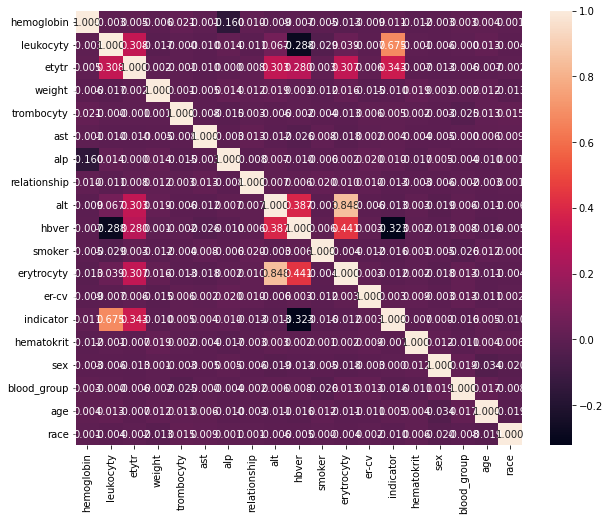

In [90]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_merged.corr(), ax=ax, annot=True, fmt=".3f")

Z pozorovania heatmapi môžeme usúdiť že najvplyvnejšími atribútmi ktoré vplývajú na indicator sú atribúty leukocyty a etytr. Tieto dva atribúty priamo vplývajú na stĺpec indicator. Leukocyty korelujú iba s atribútom etytr a inak výrazne nekorelujú už so žiadymi iným atribútom. Atribút etytr výrazne koreluje s atribútmi alt, hbver a erytrocyty.

List najvplyvnejších atribútov:
    - leukocyty
    - etytr
    - alt
    - hbver
    - erytrocyty
    
Tieto atribúty sú dôležité nakoľko všetky svojim spôsobbom ovyplyvňujú stĺpec "indicator" či už priamo alebo nepriamo. Leukocyty podľa našeho prieskumu sú najplyvnejším atribútom nakoľko sú hlavným markerom leukémie u pacienta čo nám potvrdzuje aj heatmapa. 

## 4. Replikovateľnosť predspracovania

### Zadanie  
- Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
- Očakáva sa aj využitie možnosti sklearn.pipeline

### Riešenie  

 - Pre replikovateľnosť kódu znovu načítame dataset, aby sme mohli realizovať jednoltivé časti zadania vo funkciách:  

In [91]:
# read labor and profiles dataset
df_labor_ = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles_ = pd.read_csv('../../data/profiles.csv', sep='\t')

 - spojenie datasetov cez funkciu: 

In [92]:
# https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c
class MergeTransformer(TransformerMixin):
    """
    A tranformer for merging 2 datasets.
    """
    cols = list()
    
    def __init__(self, *args, **kwargs):
        """
        Initialize method.

        :param *args: 2 datasets are instance of pandas.core.frame.DataFrame
        :param **kwargs: dictionary of names of columns
        """
        self.data1 = args[0]
        self.data2 = args[1]
        for col in kwargs.values():
            self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to merge 2 datasets in *args with columns in **kwargs.

        :param X: 2 datasets are instance of pandas.core.frame.DataFrame
        :returns: pandas.core.frame.DataFrame
        """
        X = self.data1.merge(self.data2, on=self.cols, how = 'inner')
        return X

 - odstránenie zadaných stĺpcov cez funkciu

In [93]:
class DropColsTransformer(TransformerMixin):
    """
    A tranformer for droping columns from the dataset.
    """
    
    def __init__(self, data, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param X: pandas.core.frame.DataFrame
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            X = X.drop(self.cols, axis=1)
            return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
            return X

 - numerical transformer

In [94]:
class GetNumericalTransformer(TransformerMixin):
    """
    A tranformer for getting numerical values from the dataset.
    """
    
    def __init__(self, data, col, what, category=None, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param col: col to be transformed
        :param what: dictionary, transform based on this
        :param category: change type based on this
        :param *args: -
        """
        self.data = data
        self.col = col
        self.what = what
        self.category = category
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform_age(self, born):
        """
        Computes current age.

        :param born: Date of birth 
        returns: Current age
        """
        today = date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    
    def transform(self, X, **transform_params):
        """
        Function to transform column to a numeric and change a type.

        :param X: pandas.core.frame.DataFrame
        :returns: transformed pandas.core.frame.DataFrame
        :raises keyError: raises an exception in case column was not found
        """
        try:
            if self.col != 'birthdate':
                X[self.col].replace(self.what, inplace=True)
                if self.category is not None:
                    X = X.astype({self.col: self.category})
            else:
                X = X.astype({self.col: self.category})             # get birthdate in same format 
                X[self.col] = X[self.col].apply(self.transform_age) # get age instead of birthdate
                X = X.rename(columns = {self.col: 'age'})           # rename col birthdate as age
            return X
        except KeyError:
            print(f'Something from {self.what} not found in dataset!')  

In [95]:
class PowerTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            for col in self.cols:
                 X[col] = powerTransform(X[col])
                 #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
            return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [96]:
class ScalingTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        self.method = method
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            if self.method == "Scaling":
                for col in self.cols:
                    X[col] = scalingFunct(X[col])
                     #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
                return X
            if self.method == "Standard":
                for col in self.cols:
                    X[col] = standardisatingFunct(X[col])
                     #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
                return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [97]:
class FillingTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        self.method = method
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            if self.method == "mean":
                for col in self.cols:
                    X[col] = X[col].fillna(X[col].mean())
                return X
            if self.method == "median":
                for col in self.cols:
                    X[col] = X[col].fillna(X[col].median())
                return X
            if self.method == "knn":
                for col in self.cols:
                    imputer = KNNImputer(n_neighbors=5)
                    imputer.fit(X[col].values.reshape(-1,1))
                    Xtrans = imputer.transform(X[col].values.reshape(-1,1))
                    X[col] = pd.DataFrame(Xtrans)
                return X
            if self.method == "regression":
                for col in self.cols:
                    X[col] = X[col].interpolate(method='linear')
                return X
            
            
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [98]:
class RatioFillingTransformer(TransformerMixin):
    """
    A tranformer for getting numerical values from the dataset.
    """
    
    def __init__(self,  data, colToFill, corrCol, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param col: col to be transformed
        :param what: dictionary, transform based on this
        :param category: change type based on this
        :param *args: -
        """
        self.data = data
        self.colToFill = colToFill
        self.corrCol = corrCol
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to transform column to a numeric and change a type.

        :param X: pandas.core.frame.DataFrame
        :returns: transformed pandas.core.frame.DataFrame
        :raises keyError: raises an exception in case column was not found
        """
        try:
            ratio = X[self.colToFill]/X[self.corrCol]
            X[self.colToFill] = X[self.colToFill].fillna(X[self.corrCol] * ratio.mean())
            return X
        except KeyError:
            print(f'Something from {self.what} not found in dataset!')  

 - transformácia údajov

In [99]:
df_merged_ = pd.DataFrame()

# pipeline
pipeline_obj = Pipeline(
    [
        ('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),
        ('dropCols', DropColsTransformer(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', 
                                      'current_location', 'residence', 'address')),
        ('numSex', GetNumericalTransformer(df_merged, 'sex', {"M": 0, "F": 1}, 'category')),
        ('numBlood', GetNumericalTransformer(df_merged, 'blood_group', {
                "A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8
            }, 'category')
        ),
        ('numRepairRace', GetNumericalTransformer(df_merged, 'race', {
            "blsck": "Black", "black": "Black", "white": "White"})
        ),
        ('numRace', GetNumericalTransformer(df_merged, 'race', {
            "White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5}, 'category')
        ),
        ('numSmoker', GetNumericalTransformer(df_merged, 'smoker', {
            "no": 0, "N": 0, "yes": 1, "Y": 1}, 'category')
        ),        
        ('numAge', GetNumericalTransformer(df_merged, 'birthdate', {}, 'datetime64[ns]')),
        ('numRelationship', GetNumericalTransformer(df_merged, 'relationship', {
            "married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6}, 'category')
        ),
        ('Transformer_mean',FillingTransform(df_merged, "mean", "hemoglobin", "trombocyty")),
        ('Transformer_median',FillingTransform(df_merged,"median", "er-cv", "hematokrit")),
        ('Transformer_knn',FillingTransform(df_merged,"knn", "ast", "alp")),
        ('Transformer_regression',FillingTransform(df_merged,"regression", "etytr", "alt")),
        ('Transformer_ratio',RatioFillingTransformer(df_merged, "leukocyty","etytr")),
        ('Transformer_ratio2',RatioFillingTransformer(df_merged, "erytrocyty","alt")),
        ('Transformer_ratio3',RatioFillingTransformer(df_merged, "hbver","erytrocyty")),
        ('Transformer_yeo', PowerTransform(df_merged, 'yeo-johnson', 'alt')),
        ('Transformer_scal', ScalingTransform(df_merged, "Scaling", 'ast')),
        ('Transformer_stand', ScalingTransform(df_merged, "Standard", 'alp'))
    ]
)

df_merged_ = pipeline_obj.transform(df_merged)
df_merged_


,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,age,race
0,6.77299,5.28153,4.79087,104.22450,7.22472,0.618501,0.497458,1,0.675827,9.04461,0,7.94417,61.31451,0.0,5.40103,1,2,31,2
1,7.61474,8.32651,6.31797,103.40018,7.94740,0.681911,-0.653451,1,-0.558603,5.16036,1,4.59597,55.12010,1.0,6.98459,1,2,31,2
2,4.48849,4.23617,4.02665,81.31141,6.17807,0.616801,-1.728167,1,-0.351629,3.85662,1,5.47003,59.69653,1.0,8.37171,1,2,31,2
3,8.29277,5.51242,4.48835,47.93897,7.92536,0.642844,-2.068997,4,0.213853,8.15193,1,4.55800,58.92745,0.0,5.91413,1,2,31,2
4,6.35217,5.45245,3.34754,65.03608,7.00407,0.669072,0.983211,6,-0.896902,9.09262,0,5.33302,58.00624,0.0,7.68167,0,5,115,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,7.90745,5.63301,4.44871,55.44949,6.48412,0.715746,-1.651127,3,-0.547052,8.36677,0,5.71656,54.45230,0.0,7.02299,1,6,62,2
10031,3.77544,5.10408,5.40890,77.94972,6.22491,0.713594,-3.240363,5,0.758558,7.87850,1,8.13066,51.26987,0.0,6.25302,1,6,62,2
10032,8.55132,8.53496,3.89371,72.94657,7.97233,0.704792,-2.591270,3,-0.978472,5.12016,0,4.86442,64.07401,1.0,6.42588,0,7,94,5
10033,5.18230,6.72885,9.75421,61.89897,5.47435,0.612862,-0.542006,2,1.194375,11.81792,0,8.33833,47.50924,1.0,6.26483,0,7,94,5


In [100]:
df_merged_.isna().sum()

hemoglobin      0
leukocyty       0
etytr           0
weight          0
trombocyty      0
ast             0
alp             0
relationship    0
alt             0
hbver           0
smoker          0
erytrocyty      0
er-cv           0
indicator       0
hematokrit      0
sex             0
blood_group     0
age             0
race            0
dtype: int64

### Opätovná prieskumná analýza

In [101]:
important_columns=df_merged.columns
important_columns=list(important_columns)
important_columns.remove('age')
important_columns

['hemoglobin',
 'leukocyty',
 'etytr',
 'weight',
 'trombocyty',
 'ast',
 'alp',
 'relationship',
 'alt',
 'hbver',
 'smoker',
 'erytrocyty',
 'er-cv',
 'indicator',
 'hematokrit',
 'sex',
 'blood_group',
 'race']

In [102]:
df_backup[important_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hemoglobin    10005 non-null  float64
 1   leukocyty     10004 non-null  float64
 2   etytr         10005 non-null  float64
 3   weight        10035 non-null  float64
 4   trombocyty    10005 non-null  float64
 5   ast           10005 non-null  float64
 6   alp           10004 non-null  float64
 7   relationship  10035 non-null  object 
 8   alt           10005 non-null  float64
 9   hbver         10005 non-null  float64
 10  smoker        10035 non-null  object 
 11  erytrocyty    10005 non-null  float64
 12  er-cv         10005 non-null  float64
 13  indicator     10035 non-null  float64
 14  hematokrit    10005 non-null  float64
 15  sex           10035 non-null  object 
 16  blood_group   10035 non-null  object 
 17  race          10035 non-null  object 
dtypes: float64(13), object(5)


In [103]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9936 entries, 0 to 10034
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hemoglobin    9936 non-null   float64
 1   leukocyty     9936 non-null   float64
 2   etytr         9936 non-null   float64
 3   weight        9936 non-null   float64
 4   trombocyty    9936 non-null   float64
 5   ast           9936 non-null   float64
 6   alp           9936 non-null   float64
 7   relationship  9936 non-null   float64
 8   alt           9936 non-null   float64
 9   hbver         9936 non-null   float64
 10  smoker        9936 non-null   float64
 11  erytrocyty    9936 non-null   float64
 12  er-cv         9936 non-null   float64
 13  indicator     9936 non-null   float64
 14  hematokrit    9936 non-null   float64
 15  sex           9936 non-null   float64
 16  blood_group   9936 non-null   float64
 17  age           9936 non-null   float64
 18  race          9936 non-null

<AxesSubplot:>

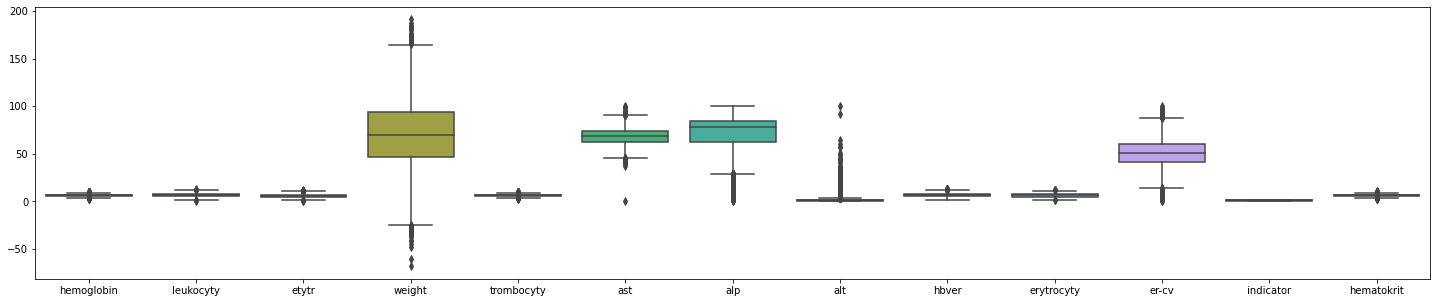

In [104]:
fig_a = plt.subplots(figsize = (25, 5))
sns.boxplot(data = df_backup[important_columns])

<AxesSubplot:>

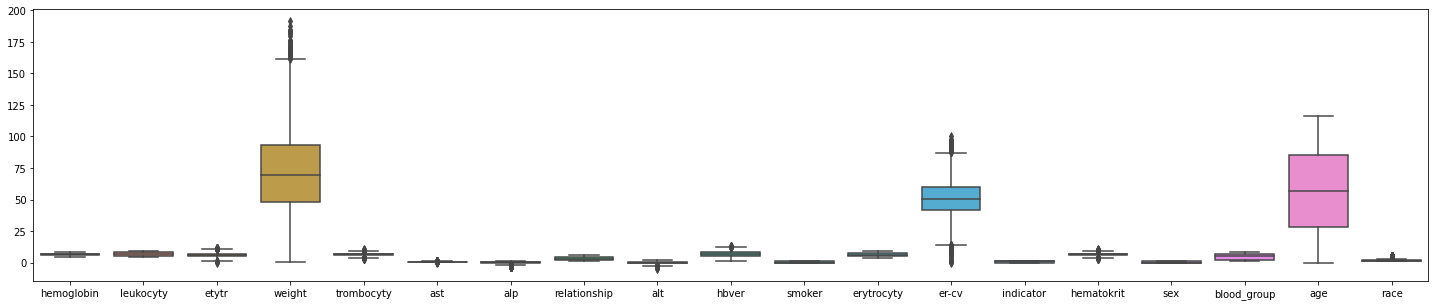

In [105]:
fig_b = plt.subplots(figsize = (25, 5))
sns.boxplot(data = df_merged)

<AxesSubplot:>

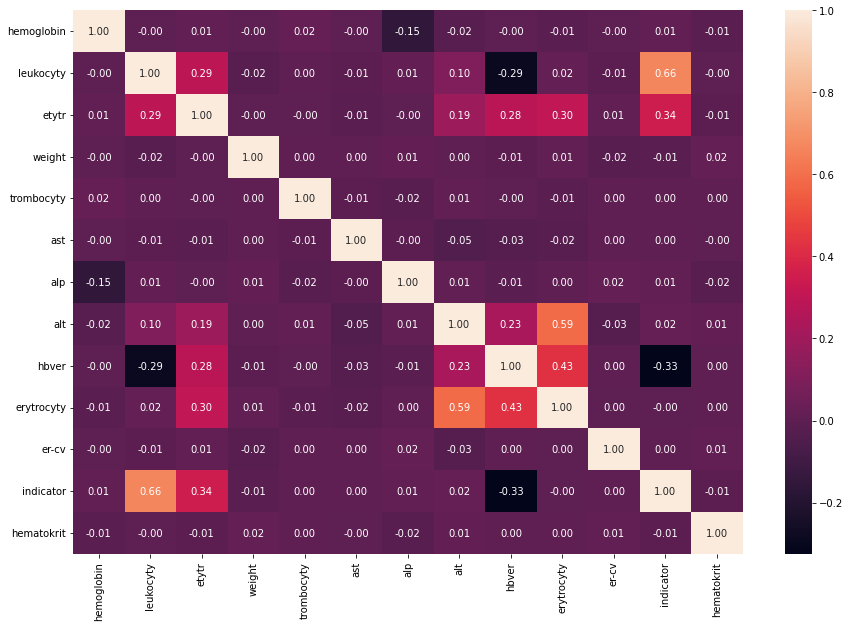

In [106]:
fig_c = plt.subplots(figsize = (15, 10))
sns.heatmap(df_backup[important_columns].corr(), fmt = ".2f", annot = True)

<AxesSubplot:>

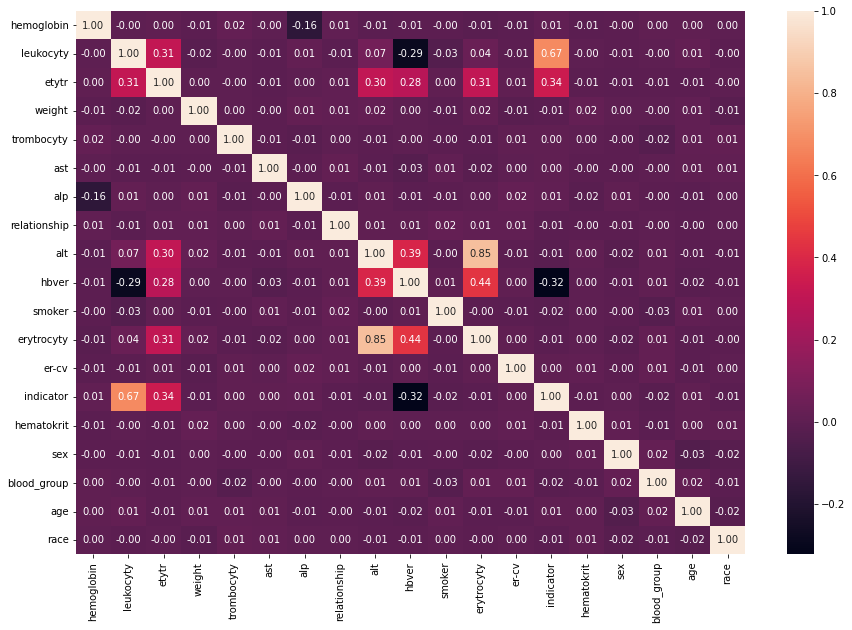

In [107]:
fig_d = plt.subplots(figsize = (15, 10))
sns.heatmap(df_merged.corr(), fmt = ".2f", annot = True)